In [1]:
import os
import sys

ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [2]:
import glob
import pandas as pd
import numpy as np

def load_mcmc_data(mcmc_files_location):
    mcmc_files = sorted(
        glob.glob(mcmc_files_location), 
        key=lambda x: int(x.split(".")[-2].split("_")[-1])
    )
    mcmc_data = []
    for file in mcmc_files:
        df = pd.read_csv(file)
        mcmc_data.append(df.loc[df.index.repeat(df.multiplicity)].iloc[:, :-1].to_numpy().astype(int))
    return mcmc_data

def load_gfn_data(gfn_files_location):
    gfn_files = sorted(
        glob.glob(gfn_files_location),
        key=lambda x: int(x.split(".")[-2].split("_")[-3])
    )
    return np.stack([pd.read_csv(f).to_numpy() for f in gfn_files])

def get_empirical_distributions(data, grid_len):
    n_samples, grid_dim = data[0].shape
    empirical_distributions = []
    
    for data_batch in data:
        counts = np.zeros(shape=(grid_len, )*grid_dim)
        np.add.at(counts, tuple(data_batch.T), 1)
        empirical_distributions.append(counts/n_samples)    
    return np.stack(empirical_distributions)

def get_l1_distribution_error(data, grid_len, expected_distribution):
    distributions = get_empirical_distributions(data, grid_len)
    l1_errors = np.abs(distributions - expected_distribution)
    mean_errors = np.mean(l1_errors, axis=tuple(range(1, l1_errors.ndim)))
    return distributions, mean_errors

# Single Vertex Spinfoam

In [3]:
gridLength = 8
spin_j = (gridLength - 1) / 2
env_name = f"single vertex spinfoam/j={float(spin_j)}"
evaluate_after_n_states = int(1e5)

gfn_data = load_gfn_data(f"{ROOT_DIR}/data/GFN/{env_name}/*")
mcmc_data = load_mcmc_data(f"{ROOT_DIR}/data/MCMC/{env_name}/draws_*.csv")

vertex = np.load(f"{ROOT_DIR}/data/EPRL_vertices/Python/Dl_20/vertex_j_{float(spin_j)}.npz")
sq_ampl = vertex**2
expected_distribution = sq_ampl / np.sum(sq_ampl)

_, gfn_l1_mean_errors = get_l1_distribution_error(gfn_data, gridLength, expected_distribution)
_, mcmc_l1_mean_errors = get_l1_distribution_error(mcmc_data, gridLength, expected_distribution)

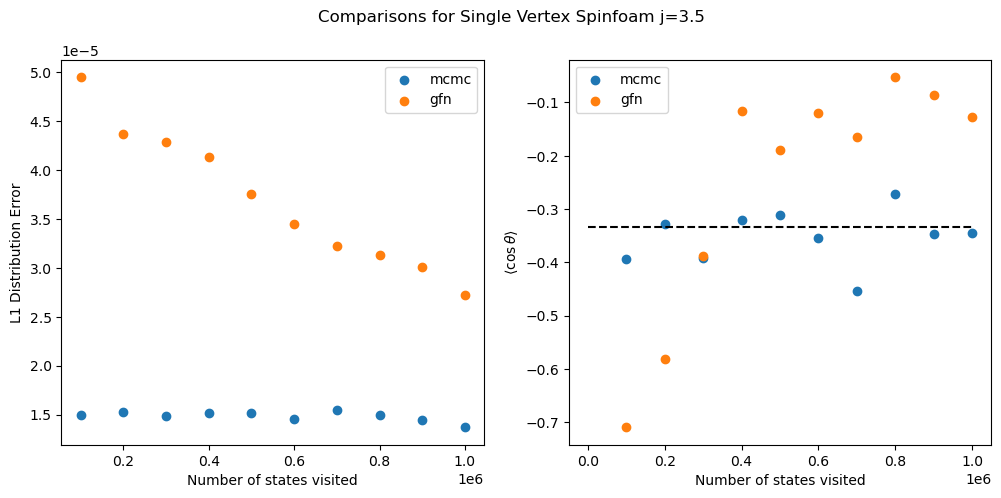

In [4]:
import matplotlib.pyplot as plt

def calculate_mean_cosine_dihedral_angle(intertwiners, spin):
    cos_angles = intertwiners*(intertwiners+1)/(2*spin*(spin+1)) - 1
    return cos_angles.mean(axis=0)[0]

mean_obs_gfn = [
    calculate_mean_cosine_dihedral_angle(intertwiners, spin_j)
    for intertwiners in gfn_data
]
mean_obs_mcmc = [
    calculate_mean_cosine_dihedral_angle(intertwiners, spin_j)
    for intertwiners in mcmc_data
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

fig.suptitle(f"Comparisons for Single Vertex Spinfoam j={spin_j}")
xs = [int((i+1)*evaluate_after_n_states) for i in range(len(mcmc_data))]

ax[0].scatter(xs, mcmc_l1_mean_errors, label="mcmc")
ax[0].scatter(xs, gfn_l1_mean_errors, label="gfn")
ax[0].legend()
ax[0].set_ylabel("L1 Distribution Error")
ax[0].set_xlabel("Number of states visited")

ax[1].scatter(xs, mean_obs_mcmc, label="mcmc")
ax[1].scatter(xs, mean_obs_gfn, label="gfn")
ax[1].legend()
# ax[1].set_ylim(-1, 1)
ax[1].hlines(-0.33333, 1, evaluate_after_n_states*len(mcmc_data), colors='k', linestyles='dashed')
ax[1].set_ylabel(r"$\langle \cos \theta \rangle$")
ax[1].set_xlabel("Number of states visited");


# Grid Peaks from GFN Paper

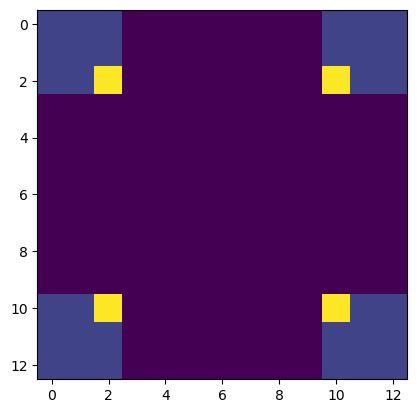

In [5]:
from src.MCMC.MCMC import grid_rewards_2d

gridLength = 13
dimensions = 2
env_name = f"GFN Paper Grid Peaks/grid_length={gridLength}, grid_dim={dimensions}"
evaluate_after_n_states = int(1e5)

gfn_data = load_gfn_data(f"{ROOT_DIR}/data/GFN/{env_name}/*")
mcmc_data = load_mcmc_data(f"{ROOT_DIR}/data/MCMC/{env_name}/draws_*.csv")

gfn_paper_rewards = grid_rewards_2d(gridLength)
expected_distribution = gfn_paper_rewards / np.sum(gfn_paper_rewards)

gfn_distributions, gfn_l1_mean_errors = get_l1_distribution_error(gfn_data, gridLength, expected_distribution)
mcmc_distributions, mcmc_l1_mean_errors = get_l1_distribution_error(mcmc_data, gridLength, expected_distribution)

plt.imshow(gfn_paper_rewards)

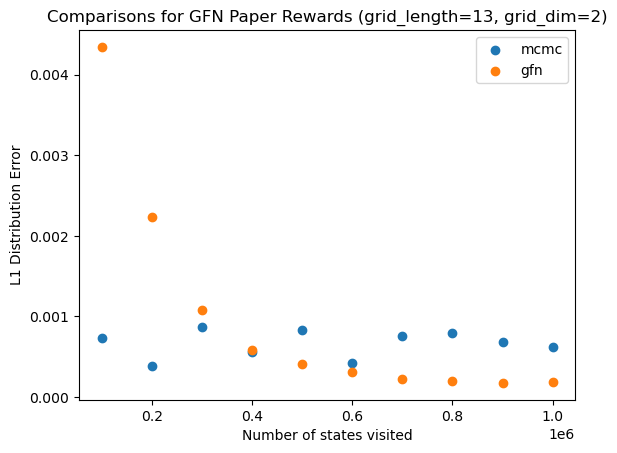

In [6]:
xs = [int((i+1)*evaluate_after_n_states) for i in range(len(mcmc_data))]

plt.scatter(xs, mcmc_l1_mean_errors, label="mcmc")
plt.scatter(xs, gfn_l1_mean_errors, label="gfn")
plt.legend()
plt.ylabel("L1 Distribution Error")
plt.xlabel("Number of states visited")

plt.title(f"Comparisons for GFN Paper Rewards (grid_length={gridLength}, grid_dim={dimensions})");

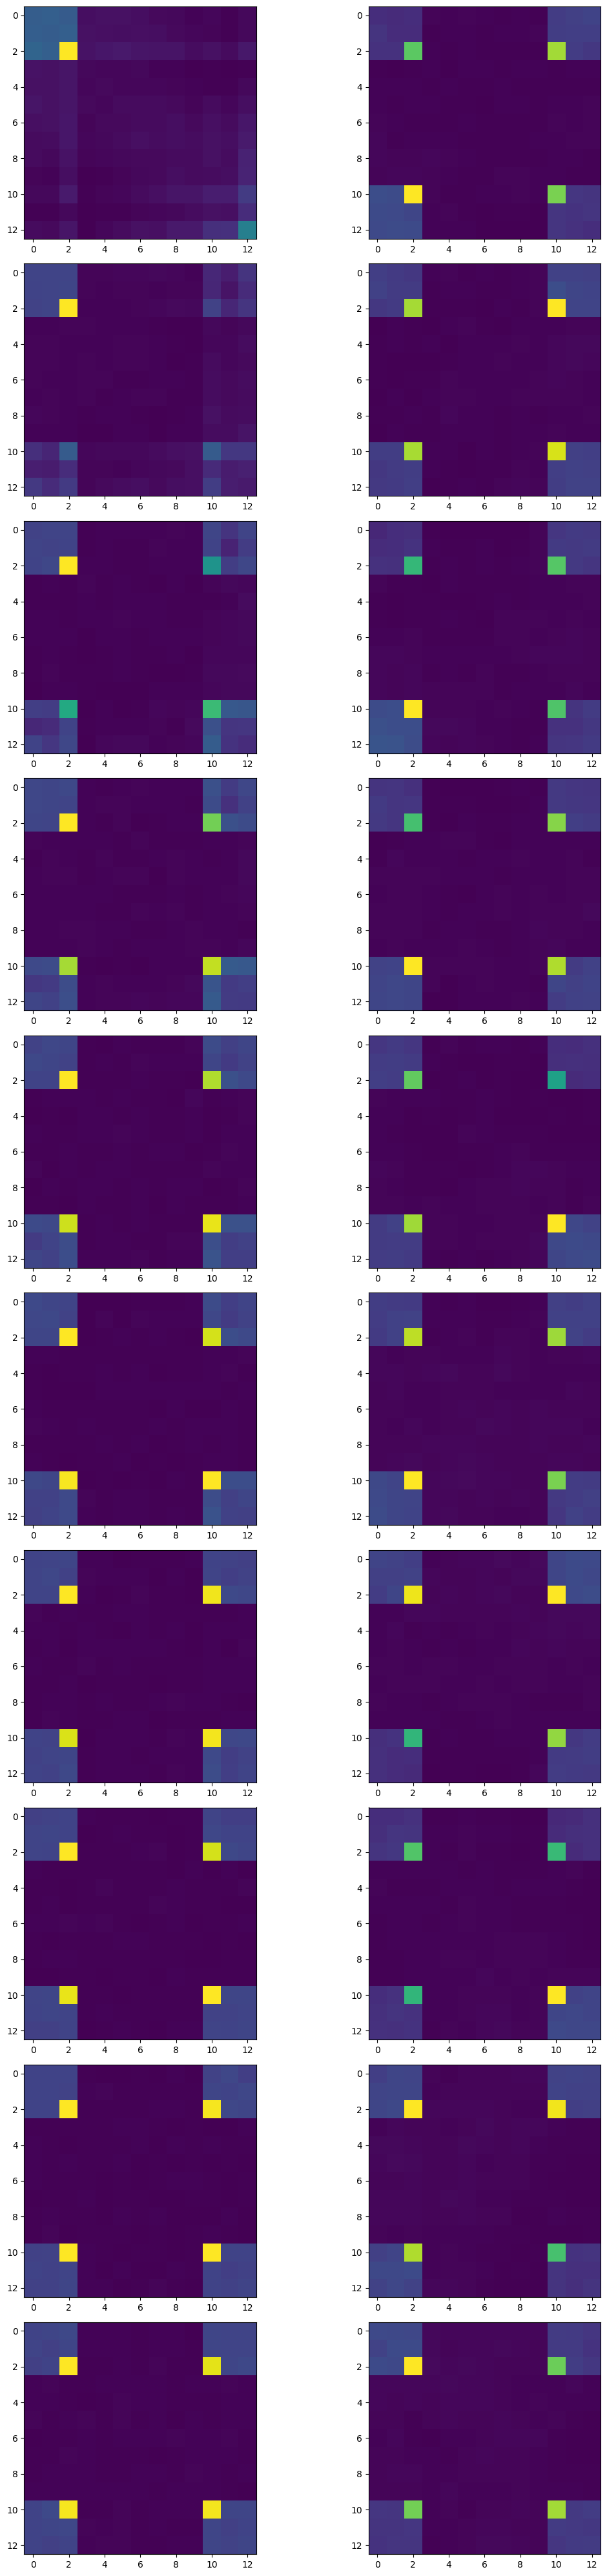

In [7]:
fig, ax = plt.subplots(nrows=len(mcmc_data), ncols=2, figsize=(12, 40))

for i, (gfn, mcmc) in enumerate(zip(gfn_distributions, mcmc_distributions)):
    ax[i, 0].imshow(gfn)
    ax[i, 1].imshow(mcmc)

plt.tight_layout()

----------------

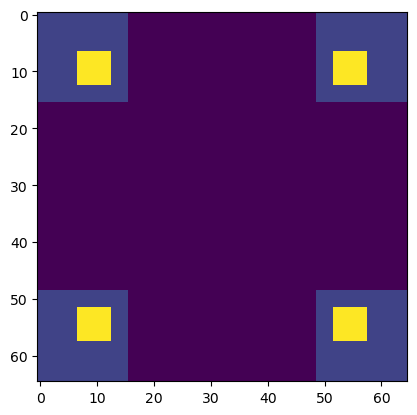

In [8]:
gridLength = 65
dimensions = 2
env_name = f"GFN Paper Grid Peaks/grid_length={gridLength}, grid_dim={dimensions}"
evaluate_after_n_states = int(1e5)

gfn_data = load_gfn_data(f"{ROOT_DIR}/data/GFN/{env_name}/*")
mcmc_data = load_mcmc_data(f"{ROOT_DIR}/data/MCMC/{env_name}/draws_*.csv")

gfn_paper_rewards = grid_rewards_2d(gridLength)
expected_distribution = gfn_paper_rewards / np.sum(gfn_paper_rewards)

gfn_distributions, gfn_l1_mean_errors = get_l1_distribution_error(gfn_data, gridLength, expected_distribution)
mcmc_distributions, mcmc_l1_mean_errors = get_l1_distribution_error(mcmc_data, gridLength, expected_distribution)

plt.imshow(gfn_paper_rewards)

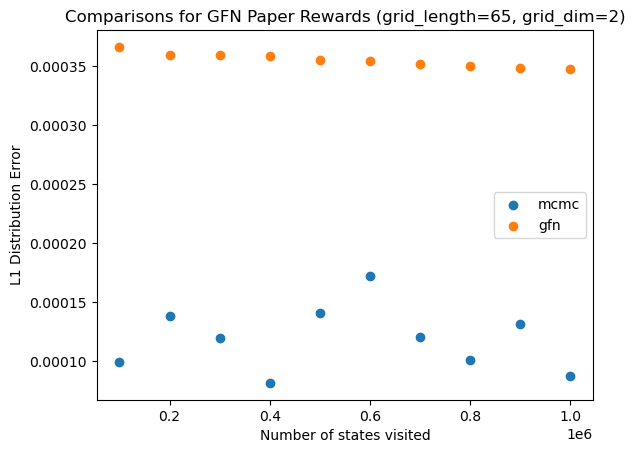

In [9]:
xs = [int((i+1)*evaluate_after_n_states) for i in range(len(mcmc_data))]

plt.scatter(xs, mcmc_l1_mean_errors, label="mcmc")
plt.scatter(xs, gfn_l1_mean_errors, label="gfn")
plt.legend()
plt.ylabel("L1 Distribution Error")
plt.xlabel("Number of states visited")

plt.title(f"Comparisons for GFN Paper Rewards (grid_length={gridLength}, grid_dim={dimensions})");

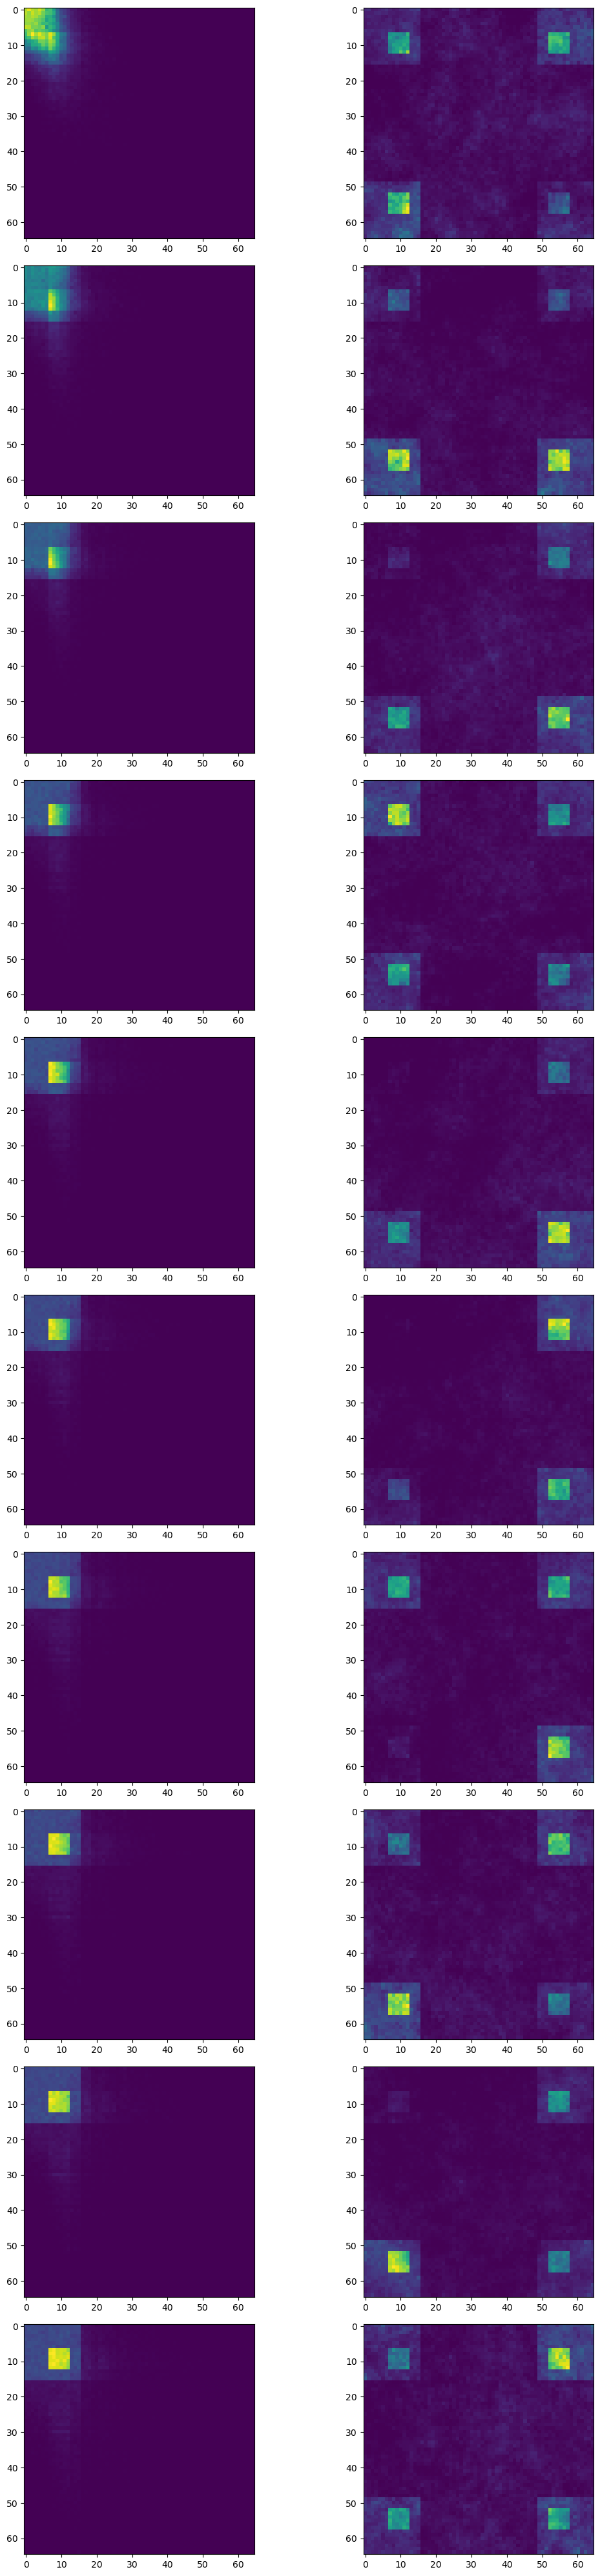

In [10]:
fig, ax = plt.subplots(nrows=len(mcmc_data), ncols=2, figsize=(12, 40))

for i, (gfn, mcmc) in enumerate(zip(gfn_distributions, mcmc_distributions)):
    ax[i, 0].imshow(gfn)
    ax[i, 1].imshow(mcmc)

plt.tight_layout()